<a href="https://colab.research.google.com/github/rameshthangam/AI-ML/blob/master/BankLoanPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, confusion_matrix, recall_score, precision_score, roc_curve
from sklearn.preprocessing import binarize, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Functions

def encoder(database, catFeatures, qtyFeatures):
  database = database[catFeatures + qtyFeatures]

  dataset_Encoded = pd.get_dummies(database, columns = catFeatures, drop_first = True)

  return dataset_Encoded

def plot_auc_curve(model, X, y):
  try:
    y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d)/ (1 + np.exp(d))

  auc = roc_auc_score(y, y_pred_prob)
  fpr,  tpr, thresholds = roc_curve(y, y_pred_prob)
  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title('ROC Curve\n AUC={auc}'.format(auc = auc ))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)


def model_training(model,X,y):
  model.fit(X,y)
  return model

from sklearn.preprocessing import Binarizer

def print_accuracy_metrics(model, X, y, threshold):
  try:
    y_pred_prob = model.predict_proba(X)[:,1]
  # except:
  #   d = model.decision_function(X)
  #   y_pred_prob = np.exp(d) / (1 + np.exp(d))
  # y_pred_class = binarize(y_pred_prob.reshape(1, -1), threshold)[0]

  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))


  # Create a Binarizer object with the specified threshold
  binarizer = Binarizer(threshold=threshold)
  y_pred_class = binarizer.transform(y_pred_prob.reshape(-1, 1)).flatten()


  print("Accurcay:", accuracy_score(y, y_pred_class))
  print("AUC:", roc_auc_score(y, y_pred_prob))
  print("Log Loss:", log_loss(y, y_pred_prob))
  print("Confusion Matrix:\n", confusion_matrix(y, y_pred_class))
  print("Recall:", recall_score(y, y_pred_class))
  print("Precision:", precision_score(y, y_pred_class))

def Find_Optimal_Cutoff(model, X, y):
  try:
    y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d)/ (1 + np.exp(d))

  fpr,  tpr, thresholds = roc_curve(y, y_pred_prob)
  i = np.arange(len(tpr))
  roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index=i)})
  roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

  print("Optimal Cutoff:", roc_t['threshold'].values)
  return(roc_t['threshold'].values)

def feature_importance(model, X):
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")
  for f in range(X.shape[1]):
      print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure(figsize=(10,5))
  plt.title("Feature Importance")
  plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices],align="center")
  plt.xticks(range(X.shape[1]),indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

# Plot calibration plots
def plot_calibration(y_true, y_prod, n_bins, model_name):
  plt.figure(figsize=(10, 10))
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
  ax2 = plt.subplot2grid((3, 1), (2, 0))

  ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

  fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prod, n_bins=n_bins)
  ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (model_name))
  ax2.hist(y_prod, range=(0, 1), bins=n_bins, histtype="step", lw=2)
  ax1.set_ylabel("Fraction of positives")
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc="lower right")
  ax1.set_title('Calibration plots  (reliability curve)')
  ax2.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  ax2.legend(loc="upper right", ncol=2)
  plt.tight_layout()
  plt.show()

In [ ]:
file_url ='https://drive.google.com/uc?export=download&id=13YvNpCckww8rNdLGxAh0tekdsehXI0HU'
df = pd.read_csv(file_url)

df.head()


,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Charged Off,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Charged Off,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Charged Off,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,"1,244.02",16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Charged Off,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Charged Off,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0


In [ ]:
df.shape

(111105, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111105 entries, 0 to 111104
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Loan_ID                       111105 non-null  object 
 1   Customer_ID                   111105 non-null  object 
 2   Loan_Status                   111105 non-null  object 
 3   Current_Loan_Amount           111105 non-null  int64  
 4   Term                          111105 non-null  object 
 5   Credit_Score                  89768 non-null   float64
 6   Years_in_current_job          106412 non-null  object 
 7   Home_Ownership                111105 non-null  object 
 8   Annual_Income                 89768 non-null   float64
 9   Purpose                       111105 non-null  object 
 10  Monthly_Debt                  111105 non-null  object 
 11  Years_of_Credit_History       111105 non-null  float64
 12  Months_since_last_delinquent  52102 non-null

In [ ]:
df.dtypes

,0
Loan_ID,object
Customer_ID,object
Loan_Status,object
Current_Loan_Amount,int64
Term,object
Credit_Score,float64
Years_in_current_job,object
Home_Ownership,object
Annual_Income,float64
Purpose,object


In [ ]:
df.describe()

,Current_Loan_Amount,Credit_Score,Annual_Income,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
count,1.111050e+05,89768.000000,8.976800e+04,111105.000000,52102.000000,111105.000000,111105.000000,1.111050e+05,1.111050e+05,110877.000000,111094.000000
mean,1.147739e+07,1075.728701,7.248575e+04,18.200991,34.902403,11.125197,0.168030,1.548342e+04,3.438644e+04,0.117662,0.029354
std,3.185533e+07,1474.007753,5.593120e+04,7.014542,21.971081,5.010249,0.484216,1.982122e+04,3.643027e+05,0.351423,0.260577
min,4.910000e+02,585.000000,4.033000e+03,3.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.162000e+03,705.000000,4.468750e+04,13.500000,16.000000,8.000000,0.000000,5.905000e+03,1.241700e+04,0.000000,0.000000
50%,1.418300e+04,724.000000,6.175200e+04,16.900000,32.000000,10.000000,0.000000,1.102700e+04,2.124300e+04,0.000000,0.000000
75%,2.382200e+04,741.000000,8.688700e+04,21.700000,51.000000,14.000000,0.000000,1.933800e+04,3.558400e+04,0.000000,0.000000
max,1.000000e+08,7510.000000,8.713547e+06,70.500000,176.000000,76.000000,15.000000,1.730472e+06,6.998809e+07,7.000000,15.000000


In [ ]:
df.loc[((df['Credit_Score'] > 850) &
        (df['Credit_Score'] < 300)), 'Credit_Score'] = np.nan

In [ ]:
df.isnull().sum()

,0
Loan_ID,0
Customer_ID,0
Loan_Status,0
Current_Loan_Amount,0
Term,0
Credit_Score,21337
Years_in_current_job,4693
Home_Ownership,0
Annual_Income,21337
Purpose,0


In [ ]:
df.groupby('Credit_Score').count()

,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
Credit_Score,,,,,,,,,,,,,,,,,,
585.0,13,13,13,13,13,13,13,13,13,13,13,4,13,13,13,13,13,13
586.0,9,9,9,9,9,7,9,9,9,9,9,3,9,9,9,9,9,9
587.0,12,12,12,12,12,12,12,12,12,12,12,6,12,12,12,12,12,12
588.0,21,21,21,21,21,21,21,21,21,21,21,11,21,21,21,21,21,21
589.0,6,6,6,6,6,6,6,6,6,6,6,2,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7470.0,54,54,54,54,54,53,54,54,54,54,54,14,54,54,54,54,54,54
7480.0,48,48,48,48,48,43,48,48,48,48,48,15,48,48,48,48,48,48
7490.0,24,24,24,24,24,23,24,24,24,24,24,10,24,24,24,24,22,24


In [ ]:
df.groupby('Loan_Status')['Loan_ID'].count()

,Loan_ID
Loan_Status,
Charged Off,25171
Fully Paid,85934


In [ ]:
loanIDCount = df.groupby('Loan_ID')['Loan_Status'].count()
loanIDCount = loanIDCount.sort_values(ascending = False)
# loanIDCount.head()
loanIDCount[0:5]

,Loan_Status
Loan_ID,
ffffe32e-ed17-459f-9cfd-7b9ee7972933,2
4d6ad857-0421-447a-9328-816bbabd2139,2
4e0a83ad-4055-4a11-b3c8-e158a08db278,2
4e07ca4f-abcd-454f-a2f1-4e55b5fefaf0,2
4e049f22-78f9-4230-ac53-2c98745cf76c,2


In [ ]:
df[df['Loan_ID'] == 'ffffe32e-ed17-459f-9cfd-7b9ee7972933']

,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
78728,ffffe32e-ed17-459f-9cfd-7b9ee7972933,97281336-1e45-41d2-acb2-263ce56a590e,Fully Paid,27902,Long Term,678.0,10+ years,Home Mortgage,117480.0,Debt Consolidation,"2,525.82",18.0,11.0,10,0,28317,62371,0.0,0.0
111027,ffffe32e-ed17-459f-9cfd-7b9ee7972933,97281336-1e45-41d2-acb2-263ce56a590e,Fully Paid,27902,Long Term,678.0,10+ years,Home Mortgage,117480.0,Debt Consolidation,"2,525.82",18.0,11.0,10,0,28317,62371,0.0,0.0


In [ ]:
#Remove Duplicates
df.drop_duplicates(inplace = True)
df.shape

(98579, 19)

In [ ]:
loanIDCount = df.groupby('Loan_ID')['Loan_Status'].count()
loanIDCount = loanIDCount.sort_values(ascending = False)
# loanIDCount.head()
loanIDCount[0:5]

,Loan_Status
Loan_ID,
bc609460-6bca-402c-a49f-90d869805cf7,2
763eb146-e045-44fc-b914-669a99c0e27b,2
9616bc3b-392d-4ae6-9c6b-50373450f987,2
c85df7c1-7908-449d-b77f-d6cbe089054b,2
9617dabf-60cc-4a27-b5a5-c53c31a1dbfe,2


In [ ]:
df[df['Loan_ID'] == '7f85733b-ef51-48e5-a0a2-1a7b68492d4e']

,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens
27947,7f85733b-ef51-48e5-a0a2-1a7b68492d4e,bc89f7d9-b603-41ee-9497-a40752183ae9,Fully Paid,11887,Short Term,NaN,4 years,Home Mortgage,NaN,Debt Consolidation,"1,287.70",16.6,26.0,11,0,32953,35471,0.0,0.0
100165,7f85733b-ef51-48e5-a0a2-1a7b68492d4e,bc89f7d9-b603-41ee-9497-a40752183ae9,Fully Paid,11887,Short Term,701.0,4 years,Home Mortgage,188214.0,Debt Consolidation,"1,287.70",16.6,26.0,11,0,32953,35471,0.0,0.0


In [ ]:
df['naCount'] = df.isnull().sum(axis=1)

In [ ]:
df.head()

,Loan_ID,Customer_ID,Loan_Status,Current_Loan_Amount,Term,Credit_Score,Years_in_current_job,Home_Ownership,Annual_Income,Purpose,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens,naCount
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Charged Off,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0,0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Charged Off,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0,1
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Charged Off,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,"1,244.02",16.7,32.0,11,1,11275,14815,1.0,0.0,0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Charged Off,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0,1
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Charged Off,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0,0


In [ ]:
df.sort_values(by=['Loan_ID', 'naCount'], inplace = True)

In [ ]:
df.drop_duplicates(subset=['Loan_ID'], keep = 'first', inplace = True)

In [ ]:
loanIDCount = df.groupby('Loan_ID')['Loan_Status'].count()
loanIDCount = loanIDCount.sort_values(ascending = False)
loanIDCount[0:5]

,Loan_Status
Loan_ID,
0000757f-a121-41ed-b17b-162e76647c1f,1
aa4ec5b8-69c5-482d-a999-b03f3f4ebd60,1
aa52d132-d9af-4482-9ca0-1bd99f6f4998,1
aa529316-dbac-48cf-9be0-96e68be3dadc,1
aa51f419-00a2-4445-a284-34f5b1cdc2d2,1


In [ ]:
print(len(df['Loan_ID'].unique()))
print(df.shape)

88908
(88908, 20)


In [ ]:
df.isnull().sum()

,0
Loan_ID,0
Customer_ID,0
Loan_Status,0
Current_Loan_Amount,0
Term,0
Credit_Score,16088
Years_in_current_job,3817
Home_Ownership,0
Annual_Income,16088
Purpose,0


In [ ]:
df.describe()

,Current_Loan_Amount,Credit_Score,Annual_Income,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Number_of_Credit_Problems,Current_Credit_Balance,Maximum_Open_Credit,Bankruptcies,Tax_Liens,naCount
count,8.890800e+04,72820.000000,7.282000e+04,88908.000000,40402.000000,88908.000000,88908.000000,8.890800e+04,8.890800e+04,88716.000000,88900.000000,88908.000000
mean,1.433911e+07,1163.139371,7.240451e+04,18.315301,35.080466,11.110463,0.160480,1.543628e+04,3.596531e+04,0.112674,0.028223,0.952659
std,3.503029e+07,1624.120461,5.771389e+04,7.049233,22.009079,4.978438,0.473751,1.965881e+04,4.041805e+05,0.343303,0.257536,0.949000
min,4.910000e+02,585.000000,4.033000e+03,3.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,8.284500e+03,711.000000,4.463750e+04,13.500000,16.000000,8.000000,0.000000,5.949000e+03,1.277500e+04,0.000000,0.000000,0.000000
50%,1.435500e+04,731.000000,6.158500e+04,17.000000,32.000000,10.000000,0.000000,1.103900e+04,2.178100e+04,0.000000,0.000000,1.000000
75%,2.448550e+04,743.000000,8.678500e+04,21.800000,51.000000,14.000000,0.000000,1.930100e+04,3.636700e+04,0.000000,0.000000,1.000000
max,1.000000e+08,7510.000000,8.713547e+06,70.500000,176.000000,76.000000,15.000000,1.730472e+06,6.998809e+07,7.000000,15.000000,5.000000


In [ ]:
df.dtypes

,0
Loan_ID,object
Customer_ID,object
Loan_Status,object
Current_Loan_Amount,int64
Term,object
Credit_Score,float64
Years_in_current_job,object
Home_Ownership,object
Annual_Income,float64
Purpose,object


In [ ]:
yearsInCurrentJobCount = df.groupby('Years_in_current_job')['Loan_ID'].count()
yearsInCurrentJobCount = yearsInCurrentJobCount.sort_values(ascending = False)
yearsInCurrentJobCount

,Loan_ID
Years_in_current_job,
10+ years,27409
2 years,8186
< 1 year,7312
3 years,7263
5 years,6084
1 year,5765
4 years,5474
6 years,5095
7 years,4943


In [ ]:
df.loc[(df['Years_in_current_job'] == '< 1 year'), 'Years_in_current_job'] = 0.5
df.loc[(df['Years_in_current_job'] == '1 year'), 'Years_in_current_job'] = 1
df.loc[(df['Years_in_current_job'] == '2 years'), 'Years_in_current_job'] = 2
df.loc[(df['Years_in_current_job'] == '3 years'), 'Years_in_current_job'] = 3
df.loc[(df['Years_in_current_job'] == '4 years'), 'Years_in_current_job'] = 4
df.loc[(df['Years_in_current_job'] == '5 years'), 'Years_in_current_job'] = 5
df.loc[(df['Years_in_current_job'] == '6 years'), 'Years_in_current_job'] = 6
df.loc[(df['Years_in_current_job'] == '7 years'), 'Years_in_current_job'] = 7
df.loc[(df['Years_in_current_job'] == '8 years'), 'Years_in_current_job'] = 8
df.loc[(df['Years_in_current_job'] == '9 years'), 'Years_in_current_job'] = 9
df.loc[(df['Years_in_current_job'] == '10+ years'), 'Years_in_current_job'] = 10

In [ ]:
df['Years_in_current_job'] = df['Years_in_current_job'].astype('float')

In [ ]:
monthlyDebtCount = df.groupby('Monthly_Debt')['Loan_ID'].count()
monthlyDebtCount = monthlyDebtCount.sort_values(ascending = False)
monthlyDebtCount

,Loan_ID
Monthly_Debt,
0,69
775.08,8
560.42,7
984.75,7
837,7
...,...
163.84,1
163.85,1
163.88,1


In [ ]:
df["Monthly_Debt"] = df["Monthly_Debt"].str.replace(",","").astype(float)
df['Monthly_Debt'] = df['Monthly_Debt'].astype('float')

In [ ]:
df.dtypes

,0
Loan_ID,object
Customer_ID,object
Loan_Status,object
Current_Loan_Amount,int64
Term,object
Credit_Score,float64
Years_in_current_job,float64
Home_Ownership,object
Annual_Income,float64
Purpose,object


In [ ]:
df.isnull().sum()

,0
Loan_ID,0
Customer_ID,0
Loan_Status,0
Current_Loan_Amount,0
Term,0
Credit_Score,16088
Years_in_current_job,3817
Home_Ownership,0
Annual_Income,16088
Purpose,0


In [ ]:
for f in ['Credit_Score',
          'Years_in_current_job',
          'Annual_Income',
          'Months_since_last_delinquent',
          'Bankruptcies', 'Tax_Liens']:
  df.loc[df[f].isnull(), f] = df[f].mean()

In [ ]:
df.isnull().sum()

,0
Loan_ID,0
Customer_ID,0
Loan_Status,0
Current_Loan_Amount,0
Term,0
Credit_Score,0
Years_in_current_job,0
Home_Ownership,0
Annual_Income,0
Purpose,0


In [ ]:
df.dtypes

,0
Loan_ID,object
Customer_ID,object
Loan_Status,object
Current_Loan_Amount,int64
Term,object
Credit_Score,float64
Years_in_current_job,float64
Home_Ownership,object
Annual_Income,float64
Purpose,object


In [ ]:
qtyFeatures = ['Current_Loan_Amount',
               'Credit_Score', 'Years_in_current_job',
               'Annual_Income', 'Monthly_Debt',
               'Years_of_Credit_History',
               'Months_since_last_delinquent', 'Number_of_Open_Accounts',
               'Current_Credit_Balance',
               'Maximum_Open_Credit',
               'Number_of_Credit_Problems', 'Bankruptcies', 'Tax_Liens'
              ]

catFeatures = ['Term', 'Home_Ownership', 'Purpose']

label = 'Loan_Status'

In [ ]:
df.groupby(['Home_Ownership'])['Loan_ID'].count()

,Loan_ID
Home_Ownership,
HaveMortgage,170
Home Mortgage,43270
Own Home,8075
Rent,37393


In [ ]:
df.loc[(df['Home_Ownership'] == 'HaveMortgage'), 'Home_Ownership'] = 'Home Mortgage'

In [ ]:
df.groupby(['Term'])['Loan_ID'].count()

,Loan_ID
Term,
Long Term,21978
Short Term,66930


In [ ]:
df.groupby(['Purpose'])['Loan_ID'].count()

,Loan_ID
Purpose,
Business Loan,1328
Buy House,559
Buy a Car,1196
Debt Consolidation,70445
Educational Expenses,92
Home Improvements,5206
Medical Bills,955
Other,2850
Take a Trip,454


In [ ]:
df.loc[(df['Purpose'] == 'other'), 'Purpose'] = 'Other'

In [ ]:
df['Loan_Status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [ ]:
# Preparing X and y using pandas:
X_encoded = encoder(df, catFeatures, qtyFeatures)

le = LabelEncoder()
y_encoded = le.fit_transform(df[label])

In [ ]:
X_encoded.head()

,Current_Loan_Amount,Credit_Score,Years_in_current_job,Annual_Income,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Current_Credit_Balance,Maximum_Open_Credit,...,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding
49725,11731,746.000000,4.0,50025.000000,355.18,11.5,35.080466,12,17391,37081,...,False,False,False,False,False,False,False,False,False,False
20733,24613,1163.139371,6.0,72404.505136,542.29,17.6,73.000000,7,14123,16954,...,False,False,False,False,False,False,False,False,False,False
15639,99999999,742.000000,3.0,64760.000000,582.84,26.8,35.080466,11,8880,22711,...,False,False,False,False,False,False,False,False,False,False
68632,11863,734.000000,10.0,69202.000000,859.26,30.3,35.080466,7,9959,16995,...,False,False,False,False,False,False,False,False,False,False
97429,13719,724.000000,1.0,34297.000000,777.38,13.6,2.000000,12,6720,53335,...,True,False,False,False,False,False,False,False,False,False


In [ ]:
y_encoded

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
# Splitting X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=1)

In [ ]:
X_train.describe()


,Current_Loan_Amount,Credit_Score,Years_in_current_job,Annual_Income,Monthly_Debt,Years_of_Credit_History,Months_since_last_delinquent,Number_of_Open_Accounts,Current_Credit_Balance,Maximum_Open_Credit,Number_of_Credit_Problems,Bankruptcies,Tax_Liens
count,7.112600e+04,71126.000000,71126.000000,7.112600e+04,71126.000000,71126.000000,71126.000000,71126.000000,7.112600e+04,7.112600e+04,71126.000000,71126.000000,71126.000000
mean,1.431050e+07,1158.965989,5.910690,7.252051e+04,963.330535,18.313215,35.044973,11.109032,1.545272e+04,3.596266e+04,0.159393,0.111997,0.027770
std,3.500120e+07,1462.810077,3.489847,5.443228e+04,636.931790,7.036877,14.821320,4.973512,1.999118e+04,3.643339e+05,0.472185,0.343266,0.253542
min,4.910000e+02,585.000000,0.500000,4.033000e+03,0.000000,3.600000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,8.234250e+03,716.000000,3.000000,4.876650e+04,534.035000,13.500000,35.080466,8.000000,5.943000e+03,1.276100e+04,0.000000,0.000000,0.000000
50%,1.435000e+04,737.000000,6.000000,7.129650e+04,844.965000,17.000000,35.080466,10.000000,1.103500e+04,2.182100e+04,0.000000,0.000000,0.000000
75%,2.446600e+04,750.000000,10.000000,7.999100e+04,1248.665000,21.800000,35.080466,14.000000,1.934275e+04,3.629700e+04,0.000000,0.000000,0.000000
max,1.000000e+08,7510.000000,10.000000,8.713547e+06,22939.120000,70.500000,176.000000,76.000000,1.730472e+06,5.930574e+07,12.000000,7.000000,11.000000


Optimal Cutoff: [0.68150939]


array([0.68150939])

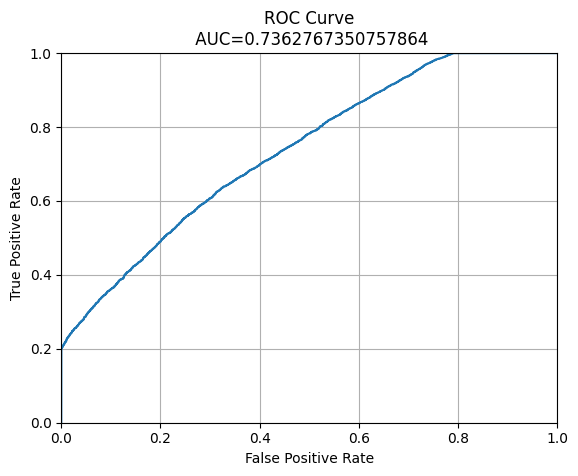

In [ ]:
# Fit logistic regression

logreg = LogisticRegression()
model_training(logreg, X_train, y_train)

plot_auc_curve(logreg, X_test, y_test)
Find_Optimal_Cutoff(logreg, X_test, y_test)


In [ ]:
print_accuracy_metrics(logreg, X_test, y_test, 0.65)

Accurcay: 0.7069508491733213
AUC: 0.7362767350757864
Log Loss: 0.47028976993545535
Confusion Matrix:
 [[ 2411  2596]
 [ 2615 10160]]
Recall: 0.7953033268101761
Precision: 0.7964879272499216


Optimal Cutoff: [0.68190136]
Accurcay: 0.7029637544639091
AUC: 0.7271438584907475
Log Loss: 0.47932735883101685
Confusion Matrix:
 [[ 9635 10529]
 [10598 40364]]
Recall: 0.7920411286841176
Precision: 0.7931149666948303


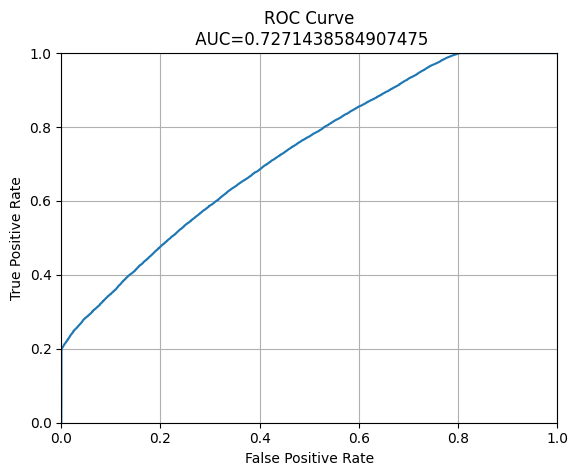

In [ ]:
plot_auc_curve(logreg, X_train, y_train)
Find_Optimal_Cutoff(logreg, X_train, y_train)
print_accuracy_metrics(logreg, X_train, y_train, 0.65)

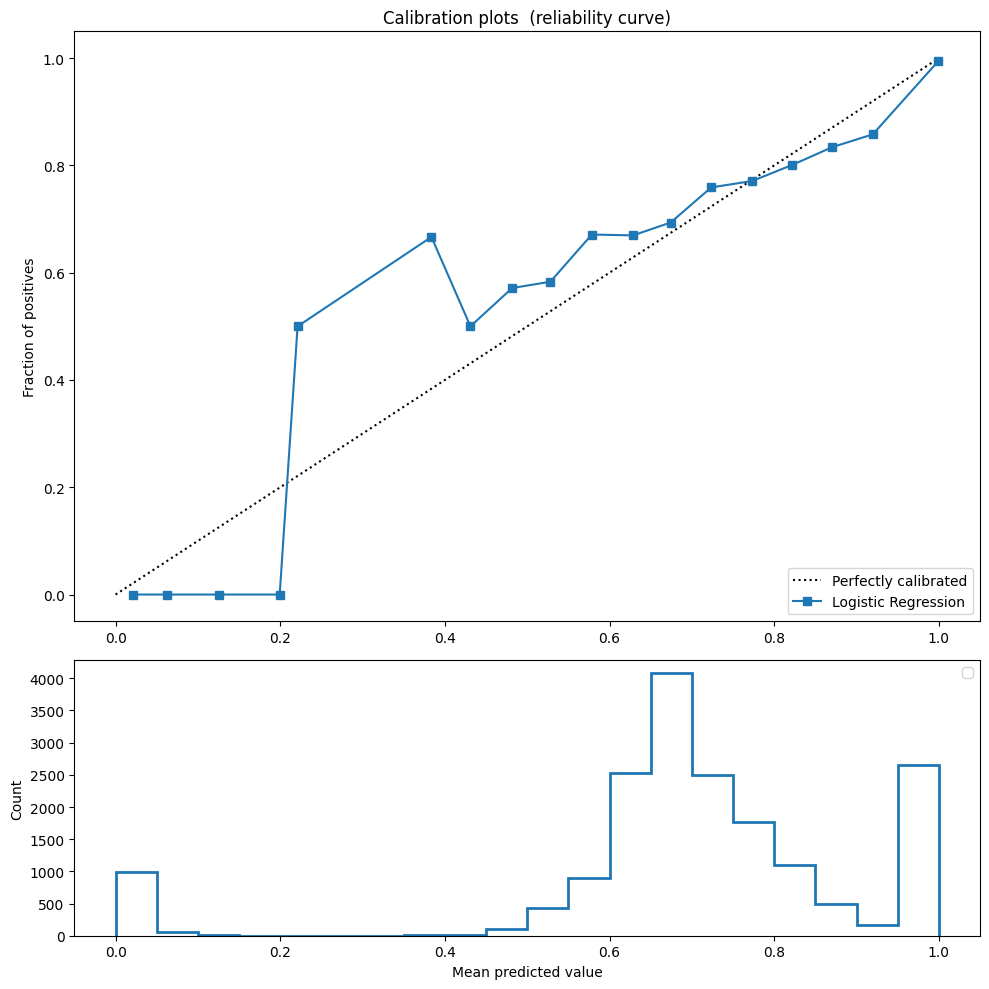

In [ ]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
plot_calibration(y_test, y_pred_prob, 20, "Logistic Regression")

In [ ]:
print(y_pred_prob)


[0.69880621 0.73593321 0.66093608 ... 0.0545114  0.69937059 0.70482183]


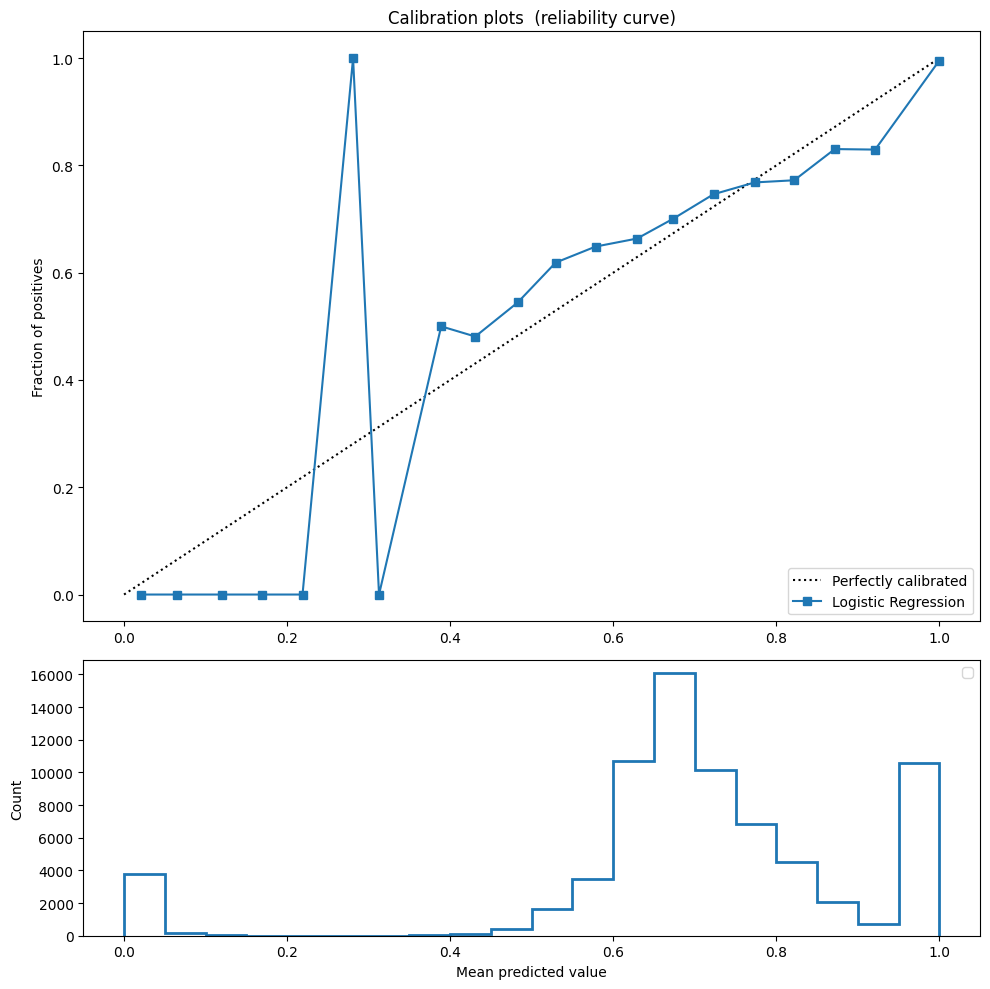

In [ ]:
y_pred_prob = logreg.predict_proba(X_train)[:, 1]
plot_calibration(y_train, y_pred_prob, 20, "Logistic Regression")

In [ ]:
print_accuracy_metrics(logreg, X_train, y_train, 0.65)

Accurcay: 0.7029637544639091
AUC: 0.7271438584907475
Log Loss: 0.47932735883101685
Confusion Matrix:
 [[ 9635 10529]
 [10598 40364]]
Recall: 0.7920411286841176
Precision: 0.7931149666948303


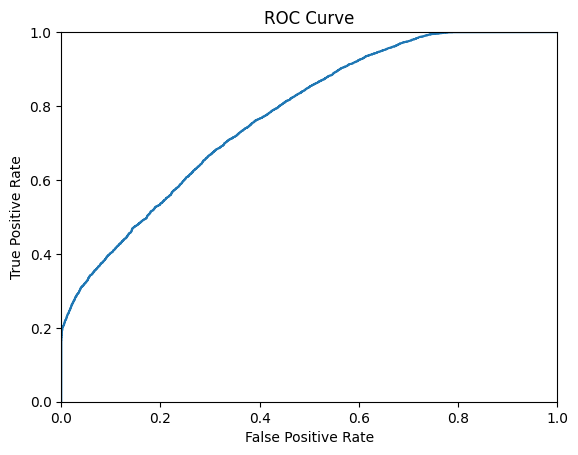

Accurcay: 0.6917107187043078
AUC: 0.774842703580936
Log Loss: 0.5467610182082978
Confusion Matrix:
 [[3352 1655]
 [3827 8948]]
Recall: 0.7004305283757338
Precision: 0.8439121003489578


In [ ]:
# Fit Logistic regression with L2 regularization (Ridge)
ridge = RidgeClassifier(alpha=1.0)
model_training(ridge, X_train, y_train)

plot_auc_curve(ridge, X_test, y_test)
Find_Optimal_Cutoff(ridge, X_test, y_test)
print_accuracy_metrics(ridge, X_test, y_test, 0.61)

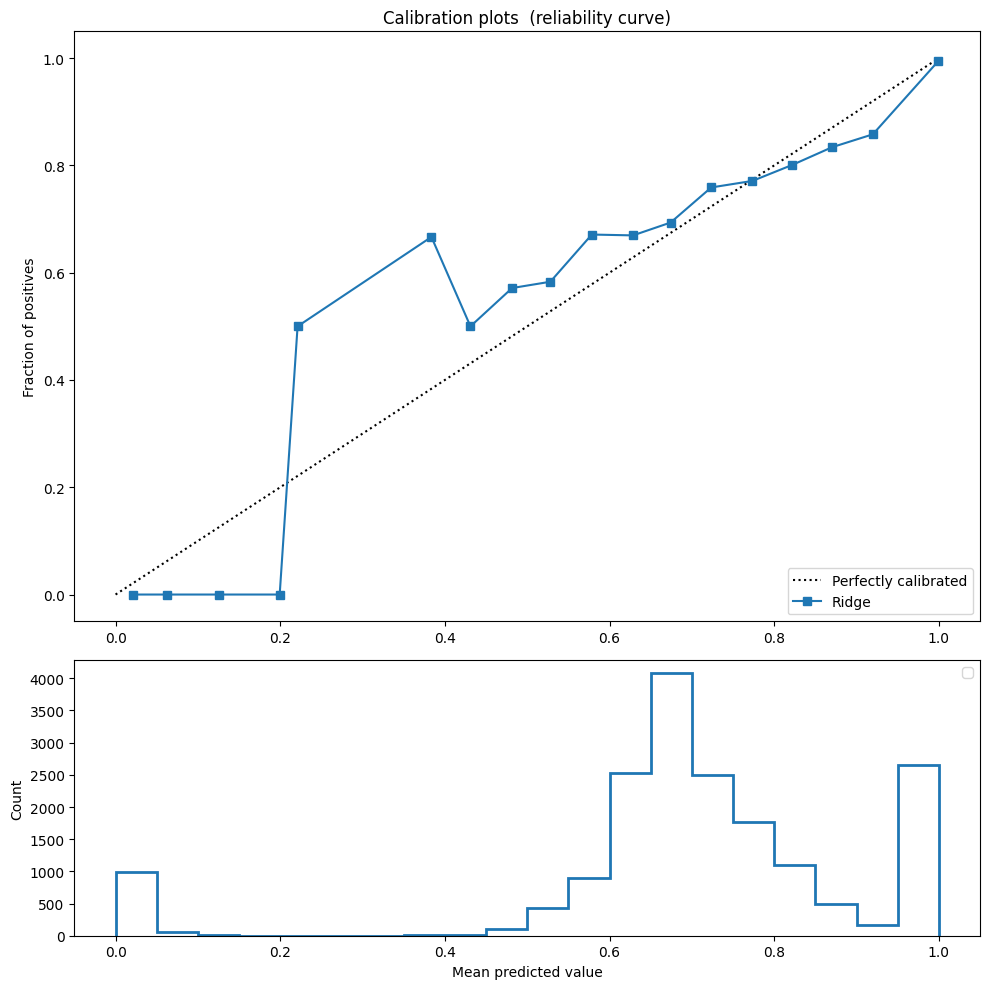

In [ ]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

plot_calibration(y_test, y_pred_prob, 20, "Ridge")

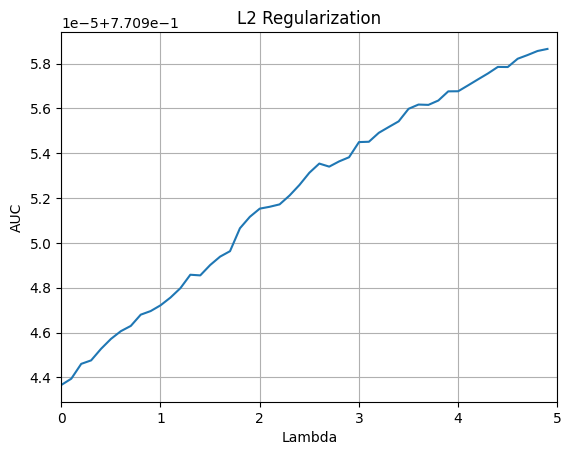

In [ ]:
alpha_range = np.arange(0.001, 5, 0.1)
scores = []
for lam in alpha_range:
  ridge = RidgeClassifier(alpha=lam)
  scores.append(cross_val_score(ridge, X_train, y_train, cv=5, scoring='roc_auc').mean())

plt.plot(alpha_range, scores)
plt.xlim([0.0, 5])
#plt.ylim([0.0, 1.0])
plt.title('L2 Regularization')
plt.xlabel('Lambda')
plt.ylabel('AUC')
plt.grid(True)

In [ ]:
scores

[0.7709436674330263,
 0.7709439448015283,
 0.7709446065257987,
 0.770944762215704,
 0.7709452779766025,
 0.7709457207416666,
 0.7709460662061656,
 0.7709462997946994,
 0.7709468009544472,
 0.7709469615220327,
 0.77094721943528,
 0.7709475648934674,
 0.7709479833427154,
 0.7709485817863742,
 0.7709485525978369,
 0.7709490148512523,
 0.7709493895380349,
 0.770949632776858,
 0.7709506545632638,
 0.7709511654715566,
 0.7709515304122607,
 0.7709516131225751,
 0.7709517201655591,
 0.7709521142765947,
 0.7709525862290428,
 0.7709531311820852,
 0.7709535398806668,
 0.7709534036674044,
 0.7709536371980058,
 0.770953822050499,
 0.7709544983491879,
 0.7709545129673243,
 0.7709549119646856,
 0.7709551698535216,
 0.7709554228761076,
 0.7709559824384685,
 0.7709561722149981,
 0.770956157615293,
 0.7709563522127241,
 0.7709567609165301,
 0.77095676574678,
 0.7709570284585066,
 0.7709572961071183,
 0.770957558890302,
 0.7709578508411787,
 0.7709578459898326,
 0.7709582157368791,
 0.7709583811263074,
 

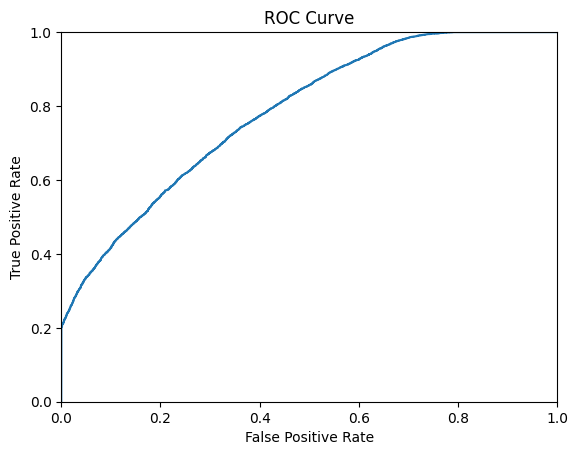

Accurcay: 0.6806883365200764
AUC: 0.7818631372047822
Log Loss: 0.4455503446004825
Confusion Matrix:
 [[3513 1494]
 [4184 8591]]
Recall: 0.6724853228962818
Precision: 0.8518591968269708


In [ ]:
# Fit Logistic regression with L1 regularization (Lasso)

lasso = LogisticRegression(penalty='l1', C=1, solver='liblinear')
model_training(lasso, X_train, y_train)

plot_auc_curve(lasso, X_test, y_test)
Find_Optimal_Cutoff(lasso, X_test, y_test)
print_accuracy_metrics(lasso, X_test, y_test, 0.73)

In [ ]:
lambda_range = np.arange(0.001, 5, 0.1)
scores = []
for lam in lambda_range:
  lasso = LogisticRegression(penalty='l1', C=1/lam, solver='liblinear')
  scores.append(cross_val_score(lasso, X_train, y_train, cv=5, scoring='roc_auc').mean())

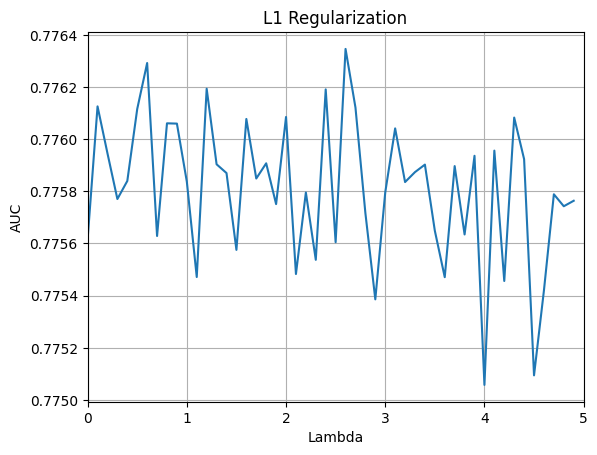

In [ ]:
plt.plot(lambda_range, scores)
plt.xlim([0.0, 5])
#plt.ylim([0.0, 1.0])
plt.title('L1 Regularization')
plt.xlabel('Lambda')
plt.ylabel('AUC')
plt.grid(True)

In [ ]:
# 2-degree Polynomial Features

poly = PolynomialFeatures(2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

print(X_test.shape)
print(X_test_poly.shape)



(17782, 30)
(17782, 496)


Optimal Cutoff: [inf]
Accurcay: 0.2815768754920706
AUC: 0.5
Log Loss: 0.6931471805599453
Confusion Matrix:
 [[ 5007     0]
 [12775     0]]
Recall: 0.0
Precision: 0.0


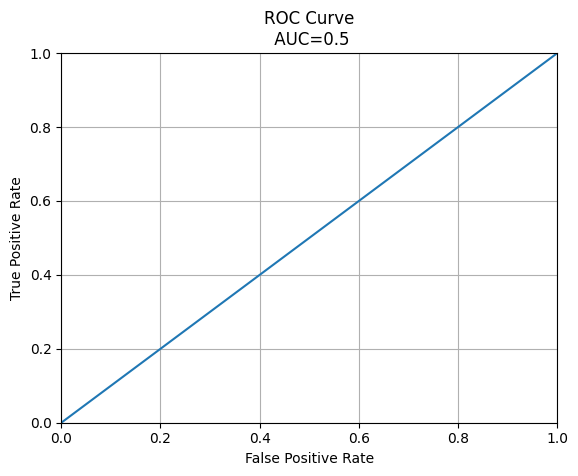

In [ ]:
logreg_poly = LogisticRegression()
model_training(logreg_poly, X_train_poly, y_train)

plot_auc_curve(logreg_poly, X_test_poly, y_test)
Find_Optimal_Cutoff(logreg_poly, X_test_poly, y_test)
print_accuracy_metrics(logreg_poly, X_test_poly, y_test, 0.75)

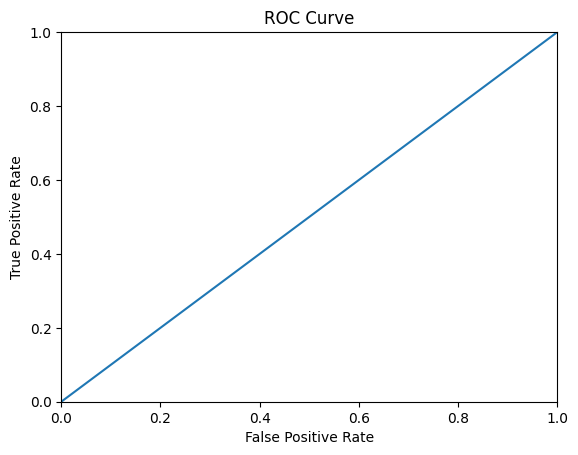

Accurcay: 0.283496892838062
AUC: 0.5
Log Loss: 0.6931471805599453
Confusion Matrix:
 [[20164     0]
 [50962     0]]
Recall: 0.0
Precision: 0.0


In [ ]:
plot_auc_curve(logreg_poly, X_train_poly, y_train)
Find_Optimal_Cutoff(logreg_poly, X_train_poly, y_train)
print_accuracy_metrics(logreg_poly, X_train_poly, y_train, 0.75)

In [ ]:
print_accuracy_metrics(logreg_poly, X_train_poly, y_train, 0.75)

Accurcay: 0.283496892838062
AUC: 0.5
Log Loss: 0.6931471805599453
Confusion Matrix:
 [[20164     0]
 [50962     0]]
Recall: 0.0
Precision: 0.0


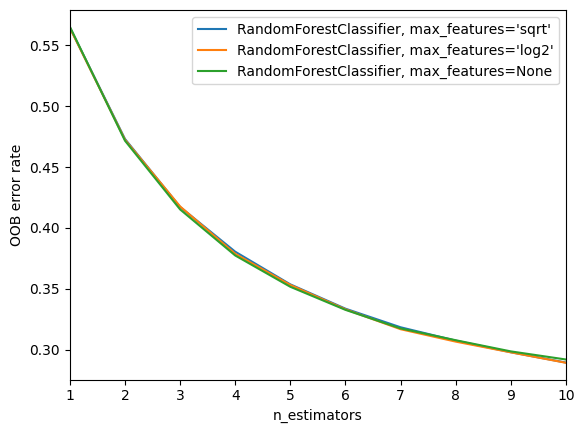

In [ ]:
# Random Forest
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 123

X = X_encoded
y = y_encoded

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 1
max_estimators = 10

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

Optimal Cutoff: [0.71]
Accurcay: 0.6758519851535261
AUC: 0.7971939714927477
Log Loss: 0.4374200526659601
Confusion Matrix:
 [[3829 1178]
 [4586 8189]]
Recall: 0.6410176125244619
Precision: 0.8742393509127789


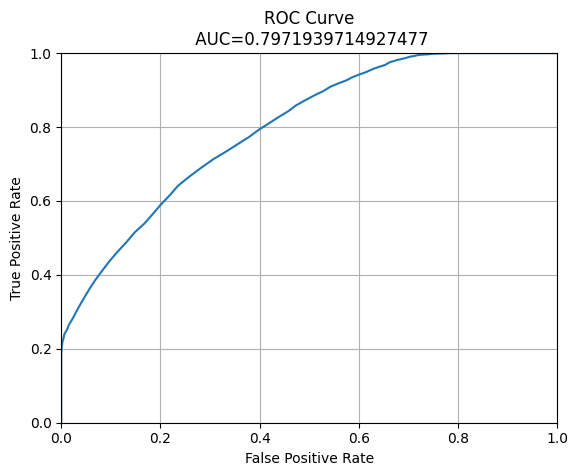

In [ ]:
rf = RandomForestClassifier(n_estimators=100,
                            criterion='gini',
                            max_features='sqrt',
                            n_jobs=-1)
model_training(rf, X_train, y_train)

plot_auc_curve(rf, X_test, y_test)
Find_Optimal_Cutoff(rf, X_test, y_test)
print_accuracy_metrics(rf, X_test, y_test, 0.73)

Optimal Cutoff: [0.71]
Accurcay: 0.6684287481723091
AUC: 0.7930039940169867
Log Loss: 0.4405668440374666
Confusion Matrix:
 [[3819 1188]
 [4708 8067]]
Recall: 0.6314677103718199
Precision: 0.8716369529983793


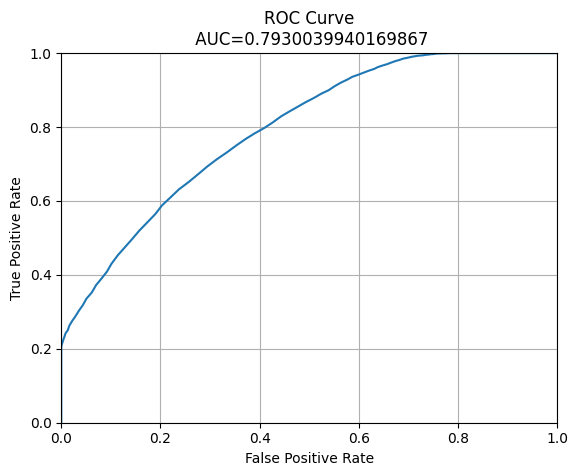

In [ ]:
rf = RandomForestClassifier(n_estimators=100,
                            criterion='gini',
                            max_features=None,
                            n_jobs=-1)
model_training(rf, X_train, y_train)

Optimal Cutoff: [0.71]
Accurcay: 0.6684287481723091
AUC: 0.7930039940169867
Log Loss: 0.4405668440374666
Confusion Matrix:
 [[3819 1188]
 [4708 8067]]
Recall: 0.6314677103718199
Precision: 0.8716369529983793


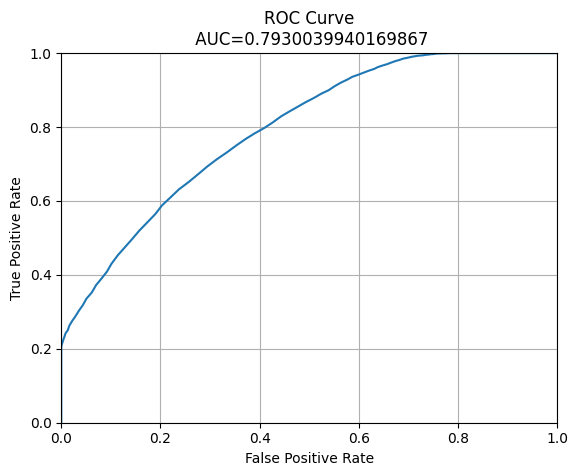

In [ ]:
plot_auc_curve(rf, X_test, y_test)
Find_Optimal_Cutoff(rf, X_test, y_test)
print_accuracy_metrics(rf, X_test, y_test, 0.73)

In [ ]:
print_accuracy_metrics(rf, X_train, y_train, 0.73)

Accurcay: 0.9941512245873521
AUC: 1.0
Log Loss: 0.12117891091350766
Confusion Matrix:
 [[20164     0]
 [  416 50546]]
Recall: 0.9918370550606335
Precision: 1.0


Feature ranking:
1. feature 1 (0.223214)
2. feature 0 (0.141096)
3. feature 9 (0.090106)
4. feature 4 (0.089153)
5. feature 8 (0.085801)
6. feature 5 (0.083513)
7. feature 3 (0.077348)
8. feature 7 (0.051122)
9. feature 6 (0.047368)
10. feature 2 (0.037114)
11. feature 13 (0.024391)
12. feature 15 (0.008022)
13. feature 10 (0.006253)
14. feature 18 (0.005950)
15. feature 14 (0.005202)
16. feature 11 (0.005032)
17. feature 22 (0.004822)
18. feature 20 (0.003658)
19. feature 12 (0.002451)
20. feature 21 (0.001900)
21. feature 17 (0.001387)
22. feature 16 (0.001212)
23. feature 27 (0.000931)
24. feature 23 (0.000890)
25. feature 24 (0.000720)
26. feature 25 (0.000429)
27. feature 29 (0.000363)
28. feature 28 (0.000333)
29. feature 19 (0.000206)
30. feature 26 (0.000012)


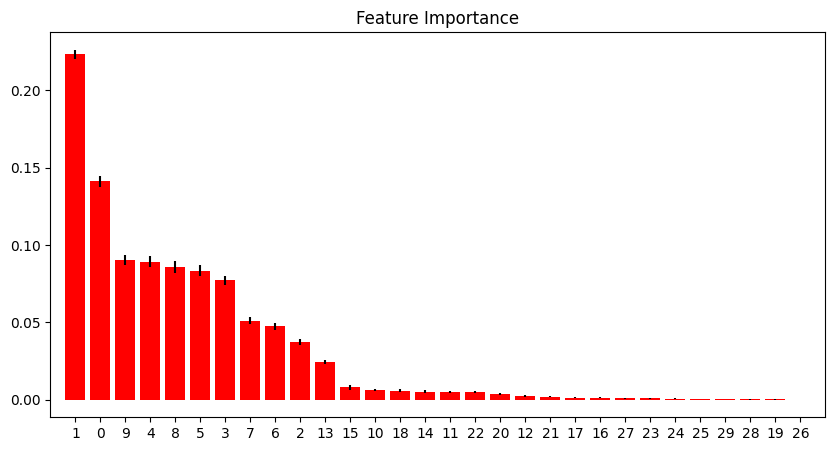

In [ ]:
# Feature Importances

feature_importance(rf, X_train)

In [ ]:
rf_poly = RandomForestClassifier(n_estimators=100,
                            criterion='gini',
                            max_features='sqrt',
                            n_jobs=-1)
model_training(rf_poly, X_train_poly, y_train)


RandomForestClassifier(n_jobs=-1)

Optimal Cutoff: [0.71]
Accurcay: 0.6647171296817006
AUC: 0.7956270145475396
Log Loss: 0.4363036331180911
Confusion Matrix:
 [[3802 1205]
 [4757 8018]]
Recall: 0.6276320939334638
Precision: 0.86934836820991


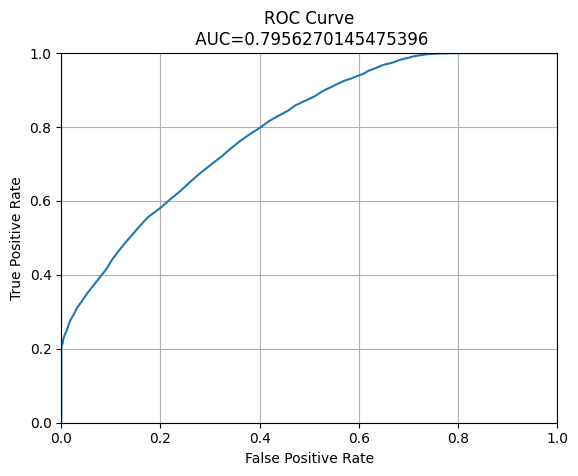

In [ ]:

plot_auc_curve(rf_poly, X_test_poly, y_test)
Find_Optimal_Cutoff(rf_poly, X_test_poly, y_test)
print_accuracy_metrics(rf_poly, X_test_poly, y_test, 0.73)

In [ ]:
# Bagging
bagging = RandomForestClassifier(n_estimators=10,
                            criterion='gini',
                            max_features=None,
                            n_jobs=-1)
model_training(bagging, X_train, y_train)



RandomForestClassifier(max_features=None, n_estimators=10, n_jobs=-1)

Optimal Cutoff: [0.8]
Accurcay: 0.6462152738724553
AUC: 0.7656792506146972
Log Loss: 0.8904011705412729
Confusion Matrix:
 [[3685 1322]
 [4969 7806]]
Recall: 0.6110371819960861
Precision: 0.855170902716915


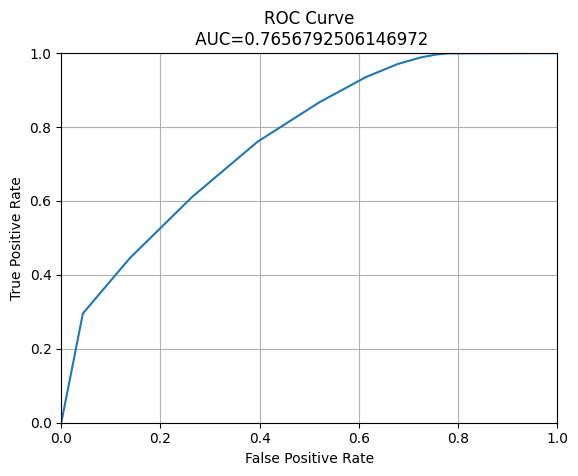

In [ ]:
plot_auc_curve(bagging, X_test, y_test)
Find_Optimal_Cutoff(bagging, X_test, y_test)
print_accuracy_metrics(bagging, X_test, y_test, 0.73)

In [ ]:
print_accuracy_metrics(bagging, X_train, y_train, 0.73)

Accurcay: 0.9469392345977561
AUC: 0.9993925098716251
Log Loss: 0.12771241935496253
Confusion Matrix:
 [[20157     7]
 [ 3767 47195]]
Recall: 0.92608217887838
Precision: 0.9998517011991017


In [ ]:
# Boosting

adaBoost = AdaBoostClassifier(n_estimators=100)
model_training(adaBoost, X_train, y_train)


AdaBoostClassifier(n_estimators=100)

Optimal Cutoff: [0.50220576]
Accurcay: 0.2815768754920706
AUC: 0.8022008092779697
Log Loss: 0.6564135187775232
Confusion Matrix:
 [[ 5007     0]
 [12775     0]]
Recall: 0.0
Precision: 0.0


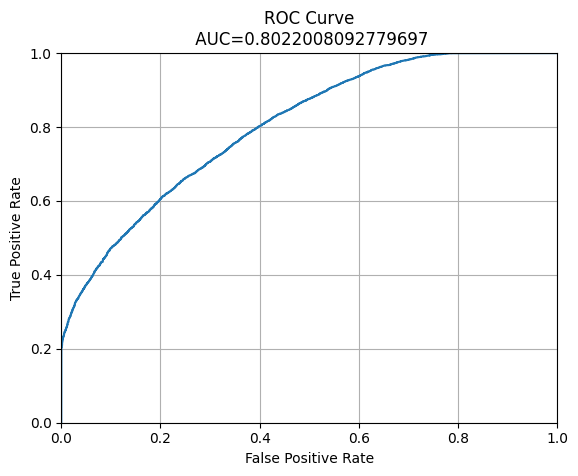

In [ ]:
plot_auc_curve(adaBoost, X_test, y_test)
Find_Optimal_Cutoff(adaBoost, X_test, y_test)
print_accuracy_metrics(adaBoost, X_test, y_test, 0.73)

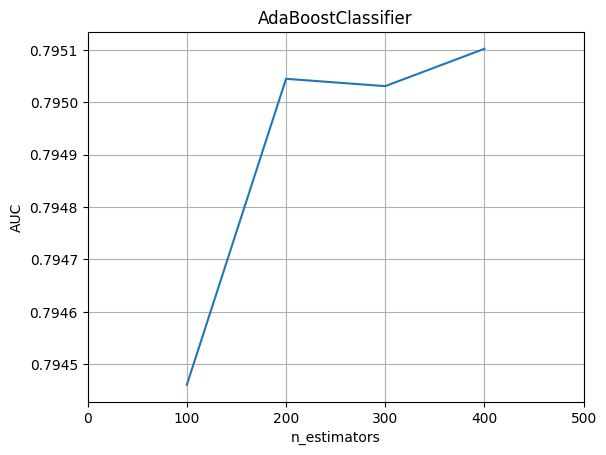

In [ ]:
n_range = np.arange(100, 500, 100)
scores = []
for n in n_range:
  adaBoost = AdaBoostClassifier(n_estimators=n)
  scores.append(cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='roc_auc').mean())


plt.plot(n_range, scores)
plt.xlim([0.0, 500])
#plt.ylim([0.0, 1.0])
plt.title('AdaBoostClassifier')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.grid(True)

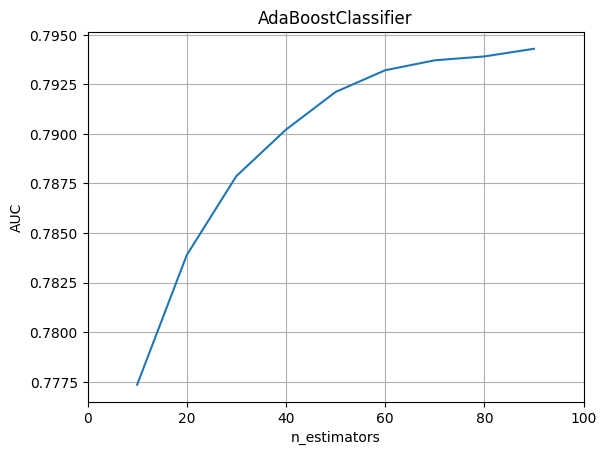

In [ ]:
n_range = np.arange(10, 100, 10)
scores = []
for n in n_range:
  adaBoost = AdaBoostClassifier(n_estimators=n)
  scores.append(cross_val_score(adaBoost, X_train, y_train, cv=5, scoring='roc_auc').mean())


plt.plot(n_range, scores)
plt.xlim([0.0, 100])
#plt.ylim([0.0, 1.0])
plt.title('AdaBoostClassifier')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.grid(True)

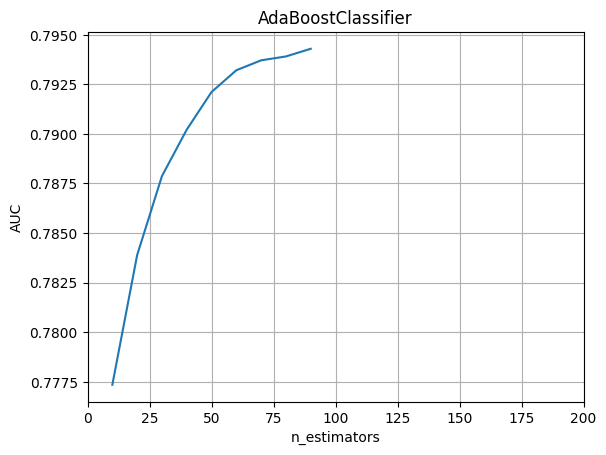

In [ ]:
plt.plot(n_range, scores)
plt.xlim([0.0, 200])
#plt.ylim([0.0, 1.0])
plt.title('AdaBoostClassifier')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.grid(True)

In [ ]:
n_range = np.arange(10, 100, 10)
print(n_range)

n_range = np.arange(100, 500, 100)
print(n_range)


[10 20 30 40 50 60 70 80 90]
[100 200 300 400]
